本项目首先从豆瓣网站上爬取2018年top250电影评论数据以及相关信息，对评论文本进行分词、统计分析。

## 加载引用工具包

In [27]:
import requests
from bs4 import BeautifulSoup
import os,socket
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jieba
from PIL import Image 
from wordcloud import WordCloud
%matplotlib inline

## 创建爬虫类

In [3]:
#创建爬虫
class Spider:
    '''
    本类用于从指定网站上爬取文本信息，并且存储到本地文件
    '''
    def __init__(self,url='https://movie.douban.com/top250',):   #实例化
        self.url = url
        self.header={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36"}
        
    #创建爬虫文件夹
    def mkdir(self,path=None):
        path = path.strip()
        #识别文件路径是否存在
        #isExists = os.path.exists(os.path.join(r"C:\Users\51429\Desktop\传胜学习资料", path))
        isExists = os.path.exists('backup')
        if not isExists:
            #os.makedirs(os.path.join(r"C:\Users\51429\Desktop\传胜学习资料", path))#根据文件路径创建文件夹
            #os.chdir(os.path.join(r"C:\Users\51429\Desktop\传胜学习资料", path))#改变当前工作目录到此文件夹
            os.makedirs('backup')
            
        return os.path.abspath('.')  #返回绝对路径
    #获取Beautifulsoup
    def get_soup(self,link):
        html = requests.get(link, headers=self.header)
        html.encoding = html.apparent_encoding
        soup = BeautifulSoup(html.text,'lxml')
        return soup

## 爬取评论数据

In [6]:
socket.setdefaulttimeout(20)  #设置超时时间为30s
spider = Spider()
path = spider.mkdir('top250')  #创建top250文件夹路径
print('starting get data from douban...')

starting get data from douban...


In [7]:
# 解析豆瓣top250数据
name_save=[] #存储电影标题
year_save=[] #存储年份
country_save=[]  #存储国家
type_save=[]   #存储电影类别
type_save2 = [] #存储单一电影类别
quote_save = [] #存储电影简评
star_save = [] #存储电影星级
#解决matplotlib 显示中文乱码
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体 SimHei为黑体
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 豆瓣电影翻页
x = 1
for i in range(1,11):
    if i == 1:
        url ='https://movie.douban.com/top250'
    else:
        url = 'https://movie.douban.com/top250'+"?start="+str(25*(i-1))+'&filter='
    main_soup = spider.get_soup(url)
    ol_grid = main_soup.find('ol',class_='grid_view')
    li = ol_grid.find_all('li')

    for l in li:
        em_rank=l.find('em').get_text()
        div_hd = l.find('div',class_='hd')
        a = div_hd.find('a')
        title = a.find('span',class_='title').get_text()
        name_save.append(title)
        #电影评分获取
        div_star = l.find('div',class_='star')
        star_num=div_star.find('span',class_='rating_num').get_text()
        star_save.append(star_num)
        
        #电影信息简介获取
        p_info = l.find('p',class_='').get_text()
        s_c = p_info.split('/')[-2].strip()
        country = s_c.split()[0]
        country_save.append(country)

        #获取电影类型数组
        l_typ = p_info.split('/')[-1].strip()#.split()
        type_save2.append(l_typ)
        for typ in l_typ.split():
            type_save.append(typ)

        s1 = ''.join(p_info.split()) #去掉字符串中的\xa0
        l_s = s1.split('/')
        if x==78:            #大闹天宫多次上映 取最早上映时间
            year = '1961'
        else:
            year = l_s[-3][-4:]  #电影上映年份
        x+=1
        year_save.append(year)
        #获取电影简评
        div_bd = l.find('div', class_='bd')
        q = div_bd.find('span', class_='inq')
        if q != None:
            quote = q.get_text()
            quote_save.append(quote)
        else:
            quote_save.append('None')

In [8]:
import pandas as pd
movie_name = name_save
movie_year = year_save
movie_country = country_save 
movie_type = type_save2
movie_quote = quote_save
movie_star = star_save
movie = {'name':movie_name,'year':movie_year, 'country':movie_country, 'type':movie_type,'quote':movie_quote,'star_num':movie_star}
movie = pd.DataFrame(movie)

In [9]:
#movie.to_csv('doubanmovie_top250.csv')
#movie

In [10]:
name_list = []
sta = {}
for i in range(1931,2018):  #柱形图x轴坐标
    name_list.append(i)
    sta[str(i)]=0
for x in year_save:#统计从1931到2017每年在榜单中的电影数量
    sta[x] += 1

num_list = []
name_list1 = []
#for key, value in sta.items():
    #if value > 0:       #只显示电影数量大于0的
        #name_list1.append(str(key))
        #num_list.append(value)
        
for item in name_list:
    name_list1.append(str(item))
    value = sta[str(item)]
    num_list.append(value)

## 电影数据图表分析

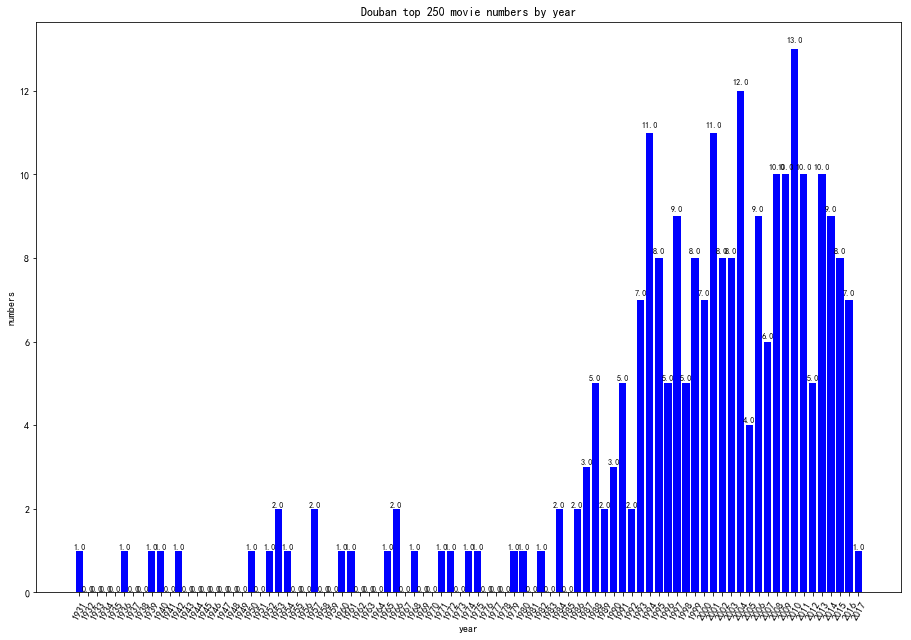

In [12]:
drawyearplot(num_list, name_list)      #电影年份图表

根据上图图示标明，2010年出品的多部电影质量一直有着较高的讨论活跃度，其次是2004年以及2001年，且21世纪以来出品电影占据top250数据绝大部分，反映出随着时代的发展，电影的制作技术，电影质量也随之有了提高，人们对于接收新时代的电影有了更高的认识

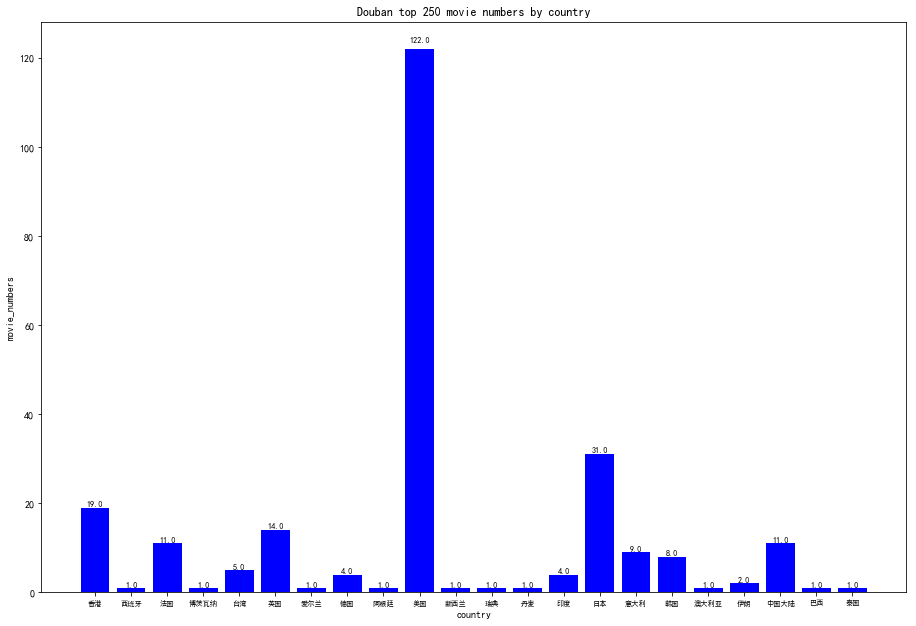

In [13]:
drawcountryplot(country_save)     #电影出品国家图表

根据上图图示表明，美国电影市场仍然占据着世界电影的主导地位，可见美国好莱坞电影的制作质量一直保持着顶尖的水平，人们在观看电影的时候更倾向选择美国好莱坞电影，在剧情，特效，电影质量等方面有着不可撼动的高度，其次日本通过其电影展现出独特的日本文化以及宣扬的哲理，也能够深深捕获人心，导致日本出品电影多次排在top250行列之中，另外港片的质量也在豆瓣影迷心中占据着一定地位，尤其表现在90年代港片的黄金时期，许多场景许多电影经典语录对人们有着深深影响，导致其多部经典电影常年上榜在豆瓣top250行列之中。

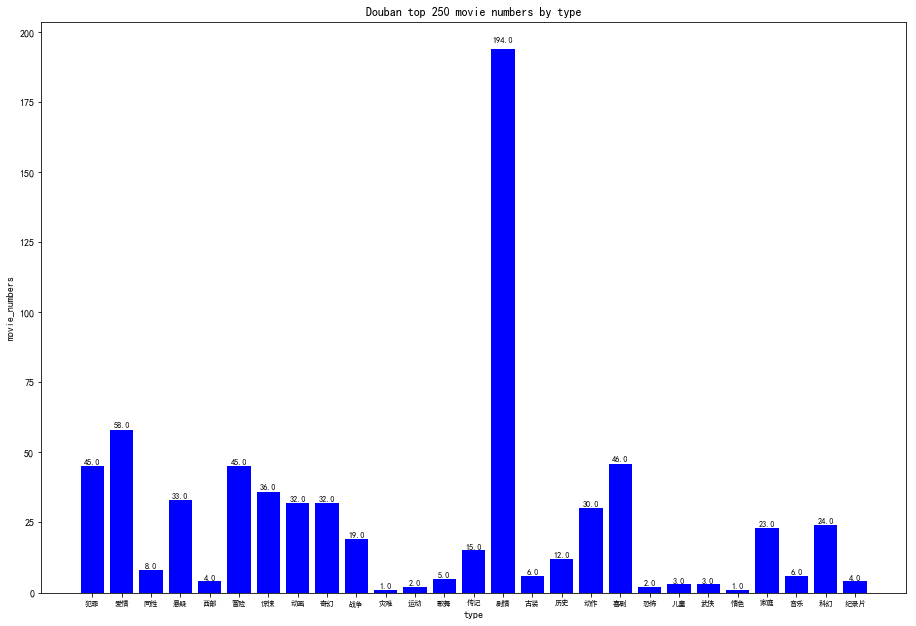

In [15]:
_ = drawtypeplot(type_save)   #电影类型图表

根据上图图示表明，剧情类电影在豆瓣电影top250深受影迷群众喜爱，该类型的讨论活跃度以及评分上榜数量遥遥领先于其他类型电影，其次是爱情，喜剧类型电影，反映出群众能否对电影印象深刻离不开一个好的故事主干，大家对于剧情类电影所拍摄出的人性百态，社会哲理更容易深入人心，另外电影对情感的探索，积极向上乐观的态度也是能够深深打动影迷的重要一部分。

## 爬取《我不是药神》短片并进行词云分析

In [12]:
filename = "我不是药神.csv"
fileheader = ["reviewer", "time", "rating", "votes", "short"]
def getHtml(url):
    try:
        r = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
        r.raise_for_status()
        r.encoding = "utf-8"
        return r.text
    except:
        print("Failed!!!")
 
f = open("backup/movieComment.txt",'wb+')

In [28]:
time_save = []
reviewer_save = []
rating_save = []
votes_save = []
short_save = []
def getData(html):
    
    soup = BeautifulSoup(html,"html.parser")
    comment_list = soup.find('div',attrs={'class':'mod-bd'})
    num = 0
    for div in comment_list.find_all('div',attrs={'class':'comment-item'}):
        num += 1
        item = {}
        item["reviewer"] = div.find_all("a")[2].get_text().strip()# 评论者
        reviewer_save.append(item["reviewer"])
        item["time"] = div.find("span",class_="comment-time").get_text().strip()# 评论时间
        time_save.append(item["time"])
        # 有的没有rating和votes 这些就不要了
        div_span=div.find("span",class_="rating")
        if(div_span==None):
            div_span == 'none'
            item["rating"] = 'none'
            item["votes"] = 'none'
            item["short"] = 'none'
            rating_save.append(item["rating"])
            short_save.append(item["short"])
            votes_save.append(item["votes"])
            continue
        item["rating"] = div.find("span",class_="rating")["title"].strip() # 评价
        rating_save.append(item["rating"])
        item["votes"] = div.find("span",class_="votes").get_text().strip() # 支持度
        votes_save.append(item["votes"])
        item["short"] = div.find("span",class_="short").get_text().strip() # 短评
        short_save.append(item["short"])
        #write2csv(item,filename,fileheader)
        comment_content = div.find('span',attrs={'class':'short'}).get_text()
        f.write(comment_content.encode('UTF-8'))
        
        
    #return time_save, reviewer_save, rating_save, votes_save, short_save
        
        
def write2csv(item,filename,fileheader):
    with open(filename,"a",encoding="utf-8",newline='') as csvFile:
        dict_writer = csv.DictWriter(csvFile, fileheader) # 创建字典写入对象
        dict_writer.writerow(item) # 写入


def seg_sentence():
    #创建停用词列表
    filefath = 'stopwords.txt'
    stopwords = [line.strip() for line in open(filefath,'r').readlines()]
 
    #实现句子的分词
    final = ''
    fn1 = open("movieComment.txt", 'r',encoding='utf-8').read() #加载爬取的内容
    sentence_seged = jieba.cut(fn1,cut_all=False) #结巴分词：精确模式
    fn2 = open("new.txt", "w", encoding='utf-8')
    for word in sentence_seged:
        if word not in stopwords:
            if word != '\t':
                final +=word
                final +=" "
    fn2.write(final)   #写入去掉停用词的内容

def wordcloud():
 
    # 加载图片
    image = Image.open("wc.jpg", 'r')
    img = np.array(image)
 
    # 词云
    cut_text = open('new.txt', 'r', encoding='utf-8').read()  # 加载去掉停用词的内容
    wordcloud = WordCloud(
        mask=img,  # 使用该参数自动忽略height,width
        height=2000,  # 设置图片高度
        width=4000,  # 设置图片宽度
        background_color='white',
        max_words=1000,  # 设置最大词数
        max_font_size=400,
        font_path="C:\Windows\Fonts\msyh.ttc",  # 如有口型乱码问题,可进入目录更换字体
    ).generate(cut_text)
 
    # 显示图片
    plot.imshow(wordcloud, interpolation='bilinear')
    plot.axis('off')  # 去掉坐标轴
    plot.show()        #直接显示
    #plot.savefig('wc1.jpg') #存为图片


In [30]:
k = 0  #start = k
i = 0
while k <200:
    url = 'https://movie.douban.com/subject/26752088/comments?start=' + str(k) + '&limit=20&sort=new_score&status=P'
    k += 20
    i += 1
    print("正在爬取第" + str(i) + "页的数据")
    #time.sleep(2) # 设置睡眠时间
    html = getHtml(url)
    getData(html)
seg_sentence()
#wordcloud()
f.close()

正在爬取第1页的数据
正在爬取第2页的数据
正在爬取第3页的数据
正在爬取第4页的数据
正在爬取第5页的数据
正在爬取第6页的数据
正在爬取第7页的数据
正在爬取第8页的数据
正在爬取第9页的数据
正在爬取第10页的数据


In [31]:
import pandas as pd
movie_time = time_save
movie_reviewer = reviewer_save
movie_rating = rating_save
movie_votes = votes_save
movie_short = short_save

In [32]:
movie_review = {'time':movie_time,'reviewer':movie_reviewer, 'rating':movie_rating, 'votes':movie_votes,'short':movie_short,}
movie_review = pd.DataFrame(movie_review)


In [33]:
movie_review.head()
#movie_review.to_csv('我不是药神_review.csv')

,rating,reviewer,short,time,votes
0,力荐,忻钰坤,“你敢保证你一辈子不得病？”纯粹、直接、有力！常常感叹：电影只能是电影。但每看到这样的佳作，...,2018-07-04,36334
1,力荐,沐子荒,王传君所有不被外人理解的坚持，都在这一刻得到了完美释放。他不是关谷神奇，他是王传君。\n你看...,2018-07-03,35081
2,力荐,凌睿,别说这是“中国版《达拉斯买家俱乐部》”了，这是中国的真实事件改编的中国电影，是属于我们自己的...,2018-06-30,23611
3,推荐,徐若风,放豆瓣语境下，是部时至今日终于拍出来的国产“高分韩国电影”——拿现实题材拍商业类型片，社会性...,2018-06-06,21591
4,推荐,桃桃淘电影,最大的病，其实是穷病。真的被感动了，整体都很成熟，也有些许韩片的影子。几个演员表演都非常出色...,2018-06-19,17477


## 电影评论数据清洗

去掉评论为空的数据，并对评论进行分词。

In [34]:
comments = movie_review.short

In [35]:
#筛除空评论
movie_review_filtered = movie_review[comments != 'none']

In [36]:
comments_filtered = movie_review_filtered.short.values

In [37]:
comments_filtered[:3]

array(['“你敢保证你一辈子不得病？”纯粹、直接、有力！常常感叹：电影只能是电影。但每看到这样的佳作，又感慨：电影不只是电影！由衷的希望这部电影大卖！成为话题！成为榜样！成为国产电影最该有的可能。',
       '王传君所有不被外人理解的坚持，都在这一刻得到了完美释放。他不是关谷神奇，他是王传君。\n你看，即使依旧烂片如云，只要还有哪怕极少的人坚持，中国影视也终于还是从中生出了茁壮的根。\n我不是药神，治不好这世界。但能改变一点，总归是会好的。',
       '别说这是“中国版《达拉斯买家俱乐部》”了，这是中国的真实事件改编的中国电影，是属于我们自己的电影。不知道就去百度一下“陆勇”，他卖印度抗癌药的时候《达拉斯买家俱乐部》还没上映呢。所以别提《达拉斯买家俱乐部》了，只会显得你无知。'],
      dtype=object)

### 词组频率统计

In [38]:
def seg_sentence(sent):
    '''
    参数
    sent: 句子，字符串
    '''
    #创建停用词列表
    filefath = 'stopwords.txt'
    stopwords = [line.strip() for line in open(filefath,'r').readlines()]
 
    #实现句子的分词
    final = ''
    sentence_seged = jieba.cut(sent,cut_all=False) #结巴分词：精确模式
    #for word in sentence_seged:
        #if word not in stopwords:
            #if word != '\t':
                #final +=word
                #final +=" "
    #转换成列表
    return list(sentence_seged)

In [39]:
#将每个句子分解成词组，将所有的词组放在一个大列表
words = []
for comment in comments_filtered:
    words.extend(seg_sentence(comment))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\richard\AppData\Local\Temp\jieba.cache
Loading model cost 1.064 seconds.
Prefix dict has been built succesfully.


In [40]:
from collections import Counter
word_freq = Counter(words)

In [41]:
words_text = ' .'.join(words)

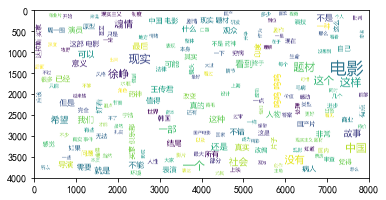

In [103]:
#画词云图
wc = WordCloud(
        #mask=img,  # 使用该参数自动忽略height,width
        height=4000,  # 设置图片高度
        width=8000,  # 设置图片宽度
        background_color='white',
        max_words=200,  # 设置最大词数
        max_font_size=400,
        font_path="C:\Windows\Fonts\msyh.ttc",  # 如有口型乱码问题,可进入目录更换字体
    )
wc.generate(words_text)
plot.imshow(wc, interpolation='bilinear')

In [23]:
#word_freq = {}
#for word in words:
    #word_freq[word] = word_freq.get(word, 0) + 1

In [109]:
#选择前20个最常见的单词
word_bar =dict(word_freq.most_common(20))
word_sorted = sorted(word_bar.items(),key = lambda x:x[1],reverse = True)
xticks1, data = zip(*word_sorted)

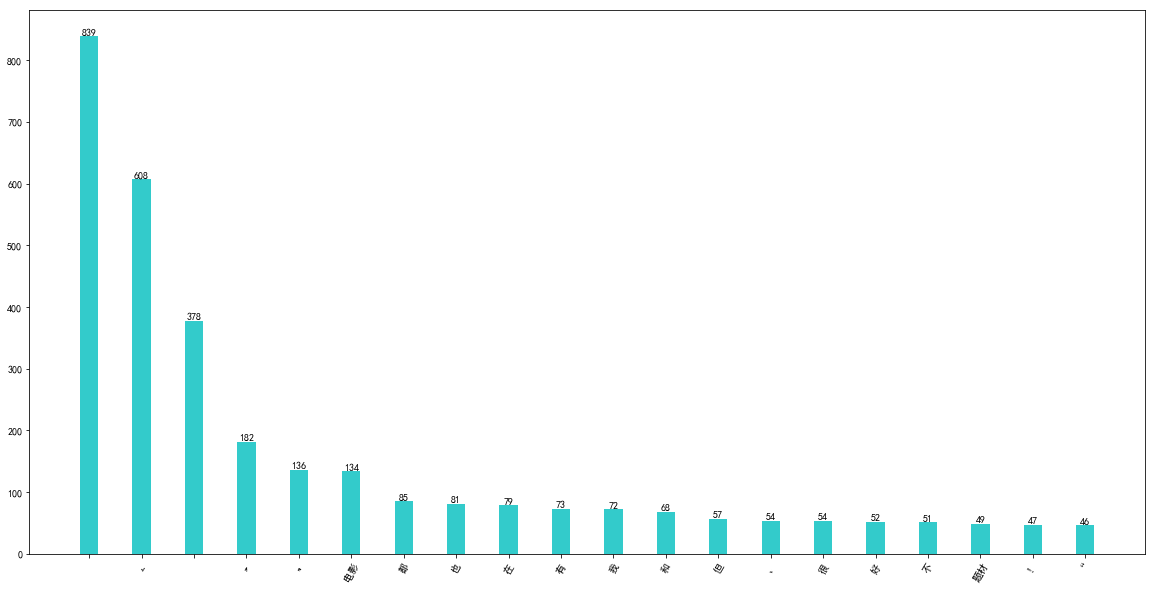

In [110]:
#柱形图
#word_bar =dict(word_freq.most_common(20))
#data = list(word_bar.values())
x_bar = list(range(20))
plt.figure(figsize=(20,10))
#xticks1 = list(word_bar.keys())
plt.bar(x_bar,data,width = 0.35,align='center',color = 'c',alpha=0.8, tick_label=xticks1)
plt.xticks(x_bar,xticks1,size='10',rotation=60)
for a,b in zip(x_bar,data):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.show()

### 评论长度分析

In [42]:
#评论字数
comment_lens = []
for comment in comments_filtered:
    comment_lens.append(len(comment))

(array([58., 40., 28., 50., 28., 32., 62., 86.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  2.]),
 array([  3.  ,  21.35,  39.7 ,  58.05,  76.4 ,  94.75, 113.1 , 131.45,
        149.8 , 168.15, 186.5 , 204.85, 223.2 , 241.55, 259.9 , 278.25,
        296.6 , 314.95, 333.3 , 351.65, 370.  ]),
 <a list of 20 Patch objects>)

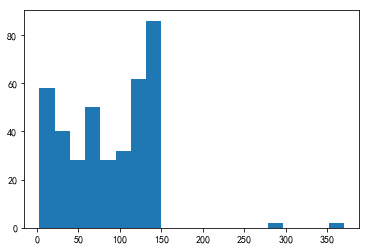

In [43]:
plt.hist(comment_lens, bins=20)

In [44]:
np.percentile(comment_lens, [25, 50, 75, 95])

array([ 39.,  90., 130., 140.])

## 建立评论情感分析系统

这里使用分类模型对文本数据进行训练和预测，首先需要将每个文本转换成向量，我们这里使用使用单词词频作为向量值。

In [45]:
movie_review_filtered.rating.unique()

array(['力荐', '推荐', '还行', '较差', '很差'], dtype=object)

In [46]:
#将五类分成三类，注意空的值默认为差评
def transform(rate):
    if rate == '力荐' or rate == '推荐':
        return '好评'
    elif rate == '还行':
        return '一般'
    else:
        return '差评'

In [47]:
#删除rating为空的行

In [48]:
movie_review_filtered['sentiment'] = movie_review_filtered.rating.map(transform)

c:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
movie_review_filtered.head()

,rating,reviewer,short,time,votes,sentiment
0,力荐,忻钰坤,“你敢保证你一辈子不得病？”纯粹、直接、有力！常常感叹：电影只能是电影。但每看到这样的佳作，...,2018-07-04,36334,好评
1,力荐,沐子荒,王传君所有不被外人理解的坚持，都在这一刻得到了完美释放。他不是关谷神奇，他是王传君。\n你看...,2018-07-03,35081,好评
2,力荐,凌睿,别说这是“中国版《达拉斯买家俱乐部》”了，这是中国的真实事件改编的中国电影，是属于我们自己的...,2018-06-30,23611,好评
3,推荐,徐若风,放豆瓣语境下，是部时至今日终于拍出来的国产“高分韩国电影”——拿现实题材拍商业类型片，社会性...,2018-06-06,21591,好评
4,推荐,桃桃淘电影,最大的病，其实是穷病。真的被感动了，整体都很成熟，也有些许韩片的影子。几个演员表演都非常出色...,2018-06-19,17477,好评


我们现在根据评论内容来预测用户的反馈是否正面性。

In [50]:
#读取评论内容以及对应的标签
comments = movie_review_filtered.short.values
labels = movie_review_filtered.sentiment.values

In [51]:
#常用的情感分析器是基于英文的，词与词之间需要有空格或者标点符号
comments_jieba = [' '.join(seg_sentence(comment)) for comment in comments]

In [52]:
comments_jieba[:2]

['“ 你 敢 保证 你 一辈子 不得 病 ？ ” 纯粹 、 直接 、 有力 ！ 常常 感叹 ： 电影 只能 是 电影 。 但 每 看到 这样 的 佳作 ， 又 感慨 ： 电影 不 只是 电影 ！ 由衷 的 希望 这部 电影 大卖 ！ 成为 话题 ！ 成为 榜样 ！ 成为 国产电影 最该 有 的 可能 。',
 '王传君 所有 不 被 外人 理解 的 坚持 ， 都 在 这 一刻 得到 了 完美 释放 。 他 不是 关谷 神奇 ， 他 是 王传君 。 \n 你 看 ， 即使 依旧 烂片 如云 ， 只要 还有 哪怕 极少 的 人 坚持 ， 中国 影视 也 终于 还是 从中 生出 了 茁壮 的 根 。 \n 我 不是 药神 ， 治不好 这 世界 。 但 能 改变 一点 ， 总归 是 会 好 的 。']

In [53]:
#划分训练数据和测试数据
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_label, test_label = train_test_split(comments_jieba, labels, test_size=0.2, random_state=42)

In [54]:
#将文本数据转化成向量
#CountVectorizer工具可以将文本表示成词语频率向量
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [57]:
#每一行对应一篇评论，每一列对应一个词组，列的值为该词组在该篇评论中出现的频率数
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [58]:
#训练一个分类器
#逻辑回归分类器
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
#训练
lr.fit(X_train, train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
#预测训练数据
predict_label = lr.predict(X_train)
#计算预测的正确率
np.mean(predict_label == train_label)
#predict_label

0.9935483870967742

In [62]:
#判断测试评论的情感
predict_label = lr.predict(X_test)
np.mean(predict_label == test_label)

0.9230769230769231

In [65]:
samples = test_texts[:4]
samples

['好看 是 料到 了 ， 没想到 拍 得 如此 朴素 、 扎实 、 流畅 。 文 牧野 是 个 实干 派 导演 ， 他 没 打算 要 一部 神作 ， 就 本本分分 讲个 好 故事 。 正因如此 ， 它 对 现实 的 关怀 才 显得 周到 、 细心 、 准确 。 徐峥 奉献 了 宋康昊 级别 的 演出 。',
 '带 着 浓浓的 宁浩味 ， 胜 在 题材 ， 和 徐峥 。 “ 世界 上 只有 一种 病 ， 穷病 ， 穷病 救 不了 的 ” ， 直白 的 说 到 了 痛处 。 一边 卖药 赚钱 ， 一边 拿 钱 买命 ， 一切 法和理 ， 都 在 “ 活着 ” 面前 脱 得 赤条条 。 最后 那段 话 为 过 审 的 目的 明显 ， 实际上 格列卫 尽管 被 列入 部分 地区 的 医保 ， 却是 有 条件 的 ， 实际 情况 哪是 这么 一句 能 总结 的 。',
 '从 印度 药神 ， 中国 药神 ， 最后 上映 成 了 我 不是 药神 ， 悲剧 改 喜剧 。 导演 镜头 设计 有 很多 瑕疵 ， 但 精准 戳 中 了 社会 情绪 点 ， 预计 票房 50 亿 。 医疗 、 警察 、 海关 系统 ， 全都 黑 了 一遍 。 没有 版权 意识 的 观众 很 容易接受 这种 思想 ： 你 花 十几 亿美元 研发 灵药 仍然 是 奸商 ， 我 不 努力 挣钱 不买 保险 不 锻炼身体 得病 就 应该 吃 到 药 。',
 '怎么 不能 拿 《 达拉斯 买家 俱乐部 》 说事 了 ？ 同样 的 题材 ， 人家 对 人性 挖掘 地多 好 ， 我们 只会 煽情 。']

In [67]:
#将评论文本转换成矩阵
samples_vectors = vectorizer.transform(samples)

In [69]:
predict_label = lr.predict(samples_vectors)
predict_label

array(['好评', '好评', '一般', '一般'], dtype=object)